In [60]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
import pandas as pd
import numpy as np

### Print table

In [63]:
import os, re, logging
import pandas as pd
#results_edited_filename = "out_bio_publish.csv"
#results_null_filename = "out_null_publish.csv"

results_edited_filename = "publish_out_bio_gpt2_pre.csv"
results_null_filename = "publish_out_bio_null_gpt2_pre.csv"

df = pd.read_csv(results_edited_filename)
# get basename of the file, and extract the title of the document.
# column 0 contains the filename, and the title is the part between the last '/' and '_edited.txt'
basenames = df.iloc[:,0].apply(os.path.basename)
# now extract the name of the document
df.loc[:, 'title'] = [re.findall(r"([A-Za-z \(\)]+)_edited[1-10]?\.*", x)[0] for x in basenames]
#df.loc[:, 'title'] = df.iloc[:,0].str.extract(r"/([A-Za-z \(\)]+)_edited[1-10]?.txt")

logging.info(f"Loaded {len(df)} rows from {results_edited_filename}")

df0 = pd.read_csv(results_null_filename)

# first extract the basename of the file:
basenames = df0.iloc[:,0].apply(os.path.basename)
# now extract the name of the document
df0.loc[:, 'title'] = [re.findall(r"([A-Za-z \(\)]+)\.*", x)[0] for x in basenames]

logging.info(f"Loaded {len(df0)} rows from {results_null_filename}")

df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
df['TPR'] = df['recall']
df_disp = df.merge(df0, on = 'title', suffixes=["", " (null)"], how='inner').filter(
    ['title', 'length', 'HC (null)', 'HC_pvalue (null)', 'edit_rate','HC', 'HC_pvalue', 'bonf', 'F1'])
print("Could not find a match to the following titles:")
print(df_disp[df_disp.isna().any(axis=1)]['title'])
df_disp = df_disp.dropna()

columns = ['title',  'edit_rate', 'length', 'HC', 'HC_pvalue', 'HC (null)',  'HC_pvalue (null)',  'bonf', 'F1']

def round_and_bold_blue(x):
    return f"\\color{{blue}} \\textbf{{{np.round(x,3)}}}"
    
def round_and_bold_red(x):
    return f"\\color{{red}} \\textbf{{{np.round(x,3)}}}"
    
df_disp = df_disp.filter(columns)
df_disp.loc[df_disp['HC_pvalue'] > 0.05, 'F1'] = "NA"
df_disp.loc[:,'length'] = df_disp['length'].apply(lambda x: f"{int(x)}")
df_disp.loc[:, 'title'] = df_disp['title'].apply(lambda x: f"\\texttt{{{x}}}")
# repalce first names with initials:
df_disp.loc[:, 'title'] = df_disp['title'].apply(lambda x: re.sub(r"([A-Z])[a-z]+ ([A-Z][a-z]+)", r"\2", x))

sig_pval = df_disp['HC_pvalue'] < 0.05
df_disp.loc[sig_pval, 'HC'] = df_disp.loc[sig_pval, 'HC'].apply(round_and_bold_blue)
sig_pval_null = df_disp['HC_pvalue (null)'] < 0.05
df_disp.loc[sig_pval_null, 'HC (null)'] = df_disp.loc[sig_pval_null, 'HC (null)'].apply(round_and_bold_red)
sig_pval_bonf = df_disp['bonf'] < 0.05
df_disp.loc[sig_pval_bonf, 'bonf'] = df_disp.loc[sig_pval_bonf, 'bonf'].apply(round_and_bold_red)
#df_disp.loc[:, 'HC_pvalue (null)'] = df_disp['HC_pvalue (null)'].apply(round_and_bold_red)
#df_disp.loc[:, 'HC_pvalue'] = df_disp['HC_pvalue'].apply(round_and_bold)
# for all column name, replace all '_' in column title with '-'
df_disp.columns = df_disp.columns.str.replace("_", "-")
aa = df_disp.set_index('title')
print(aa.to_latex(float_format=lambda x: '%.2f' % x))

Could not find a match to the following titles:
14    Agatha Christie
Name: title, dtype: object
\begin{tabular}{lrllrrrll}
\toprule
 & edit-rate & length & HC & HC-pvalue & HC (null) & HC-pvalue (null) & bonf & F1 \\
title &  &  &  &  &  &  &  &  \\
\midrule
\texttt{Camus} & 0.17 & 71 & 1.52 & 0.13 & 0.32 & 0.82 & 0.34 & NA \\
\texttt{Kafka} & 0.21 & 64 & \color{blue} \textbf{1.836} & 0.04 & 0.98 & 0.42 & 0.20 & 0.29 \\
\texttt{Garcia Marquez} & 0.19 & 53 & -0.22 & 0.92 & -1.44 & 0.98 & 2.33 & NA \\
\texttt{Chekhov} & 0.10 & 65 & 1.59 & 0.10 & 1.38 & 0.19 & \color{red} \textbf{0.048} & NA \\
\texttt{Morrison} & 0.22 & 60 & 0.47 & 0.75 & -0.96 & 0.98 & 2.51 & NA \\
\texttt{Hesse} & 0.20 & 66 & \color{blue} \textbf{2.003} & 0.02 & 1.22 & 0.27 & 0.07 & 0.52 \\
\texttt{Simenon} & 0.18 & 69 & 1.28 & 0.24 & -0.06 & 0.91 & \color{red} \textbf{0.047} & NA \\
\texttt{Tolstoy} & 0.24 & 65 & 1.49 & 0.14 & -0.38 & 0.95 & 1.35 & NA \\
\texttt{Rice} & 0.18 & 52 & 0.95 & 0.43 & -1.18 & 0.99 & 0.06 &

## Combine two experiments

In [57]:
import logging
import os, re
logging.basicConfig(level=logging.INFO)


def arrange_results(results_edited_filename, results_null_filename):
    df = pd.read_csv(results_edited_filename)
    # get basename of the file, and extract the title of the document.
    basenames = df.iloc[:,0].apply(os.path.basename)
    # now extract the name of the document
    df.loc[:, 'title'] = [re.findall(r"([A-Za-z \(\)]+)_edited[1-10]?\.*", x)[0] for x in basenames]
    logging.info(f"Loaded {len(df)} rows from {results_edited_filename}")

    df_null = pd.read_csv(results_null_filename)
    # first extract the basename of the file:
    basenames = df_null.iloc[:,0].apply(os.path.basename)
    # now extract the name of the document
    df_null.loc[:, 'title'] = [re.findall(r"([A-Za-z \(\)]+)\.*", x)[0] for x in basenames]
    logging.info(f"Loaded {len(df_null)} rows from {results_null_filename}")

    df_disp = df.merge(df_null, on = 'title', suffixes=["", " (null)"], how='inner')
        
    print("Could not find a match to the following titles:")
    #print(df_disp[df_disp.filter(['title', 'length']).isna().any(axis=1)]['title'])

    df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
    df['TPR'] = df['recall']

    columns = ['title',  'edit_rate', 'length', 'HC', 'HC_pvalue', 'HC (null)',  'HC_pvalue (null)',  'bonf', 'bonf (null)', 'F1']
    
    return df_disp.filter(columns)


INFO:root:Loaded 18 rows from publish_out_bio_gpt2_pre.csv


INFO:root:Loaded 18 rows from publish_out_bio_phi2_pre.csv
INFO:root:Loaded 18 rows from publish_out_bio_null_gpt2_pre.csv
INFO:root:Loaded 18 rows from publish_out_bio_null_phi2_pre.csv


Could not find a match to the following titles:
Series([], Name: title, dtype: object)
Series([], Name: title, dtype: object)


In [59]:
df_disp1 = arrange_results(results_edited_filename1, results_null_filename1)
df_disp2 = arrange_results(results_edited_filename2, results_null_filename2)

INFO:root:Loaded 18 rows from publish_out_bio_gpt2_pre.csv
INFO:root:Loaded 18 rows from publish_out_bio_null_gpt2_pre.csv
INFO:root:Loaded 18 rows from publish_out_bio_phi2_pre.csv
INFO:root:Loaded 18 rows from publish_out_bio_null_phi2_pre.csv


Could not find a match to the following titles:
Could not find a match to the following titles:


### Merge results of both models to one table:

In [41]:
model1 = 'gpt2'
model2 = 'phi2'

df_merged = df_disp1.merge(df_disp2, on = ['title', 'edit_rate', 'length'], suffixes=[" (gpt2)", " (phi2)"], how='outer')

df_merged.to_csv("publich_bio_merged.csv")

columns = ['title',  'length', 'edit_rate', 
        f'HC (null) ({model1})', f'HC_pvalue (null) ({model1})', f'HC ({model1})', f'HC_pvalue ({model1})', f'bonf ({model1})', f'bonf (null) ({model1})',
        f'HC (null) ({model2})', f'HC_pvalue (null) ({model2})', f'HC ({model2})', f'HC_pvalue ({model2})', f'bonf ({model2})', f'bonf (null) ({model2})',
]
df_disp = df_merged.filter(columns)

# def round_and_bold_blue(x):
#     return f"\\color{{blue}} \\textbf{{{np.round(x,3)}}}"
    
# def round_and_bold_red(x):
#     return f"\\color{{red}} \\textbf{{{np.round(x,3)}}}"

def arrange_and_color(x: float, pvalue, color) -> str:
    # round x to 2 decilmal places and pvalue to 4 decimal places:
    if pvalue < 0.05:
        stat_str = f"{{\\color{{{color}}} {{{np.round(x,2)}}}}}"
        pvalue_str = f"\\textbf{{{np.round(pvalue, 4)}}}"
    else:
        stat_str = f"{np.round(x, 2)}"
        pvalue_str = str(np.round(pvalue, 4))
    return f"{stat_str} ({pvalue_str})"

def arrange_and_color_red(x: float, pvalue) -> str:
    return arrange_and_color(x, pvalue, 'red')
def arrange_and_color_blue(x: float, pvalue) -> str:
    return arrange_and_color(x, pvalue, 'blue')
def add_color_scaler(x: float, color='blue') -> str:
    if x < 0.05:
        return f"{{\\color{{{color}}} {{{np.round(x,2)}}}}}"
    else:
        return f"{np.round(x, 2)}"
    

for model in [model1, model2]: # write Pvalues in the format stat (pvalue):
    df_disp[f'HC ({model})'] = df_disp.apply(lambda row: arrange_and_color_blue(row[f'HC ({model})'], row[f'HC_pvalue ({model})']), axis=1)
    df_disp[f'HC (null) ({model})'] = df_disp.apply(lambda row: arrange_and_color_red(row[f'HC (null) ({model})'], row[f'HC_pvalue (null) ({model})']), axis=1)

    df_disp[f'bonf ({model})'] = df_disp[f'bonf ({model})'].apply(add_color_scaler, color='blue')
    df_disp[f'bonf (null) ({model})'] = df_disp[f'bonf (null) ({model})'].apply(add_color_scaler, color='red')

# remove the pvalues from the dataframe:
df_disp = df_disp.drop(columns=[f'HC_pvalue ({model1})', f'HC_pvalue ({model2})', f'HC_pvalue (null) ({model1})', f'HC_pvalue (null) ({model2})'])

df_disp.columns = df_disp.columns.str.replace("_", "-")

# only keep the last name:
df_disp.loc[:, 'title'] = df_disp['title'].apply(lambda x: x.split()[-1])

aa = df_disp.set_index('title')
print(aa.to_latex(
    float_format=lambda x: '%.2f' % x
    ))

\begin{tabular}{lrrllllllll}
\toprule
 & length & edit-rate & HC (null) (gpt2) & HC (gpt2) & bonf (gpt2) & bonf (null) (gpt2) & HC (null) (phi2) & HC (phi2) & bonf (phi2) & bonf (null) (phi2) \\
title &  &  &  &  &  &  &  &  &  &  \\
\midrule
Camus & 71 & 0.17 & 0.32 (0.816) & 1.52 (0.1298) & 0.27 & 2.69 & {\color{red} {1.82}} (\textbf{0.0458}) & {\color{blue} {3.06}} (\textbf{0.0}) & {\color{blue} {0.05}} & 0.63 \\
Kafka & 64 & 0.21 & 0.98 (0.4222) & {\color{blue} {1.84}} (\textbf{0.0432}) & 0.16 & 1.92 & 1.7 (0.0634) & {\color{blue} {2.71}} (\textbf{0.0005}) & 0.06 & 0.05 \\
Marquez & 53 & 0.19 & -1.44 (0.9847) & -0.22 (0.925) & 2.31 & 5.21 & 0.98 (0.4025) & 1.6 (0.0836) & {\color{blue} {0.03}} & {\color{red} {0.03}} \\
Chekhov & 65 & 0.10 & 1.4 (0.1821) & 1.66 (0.0783) & {\color{blue} {0.04}} & {\color{red} {0.04}} & 1.39 (0.1838) & {\color{blue} {2.38}} (\textbf{0.0046}) & 0.05 & 0.05 \\
Morrison & 60 & 0.22 & -0.96 (0.9845) & 0.49 (0.743) & 2.34 & 2.43 & -1.01 (0.9864) & 0.88 (0.5

## Sentences in a single article

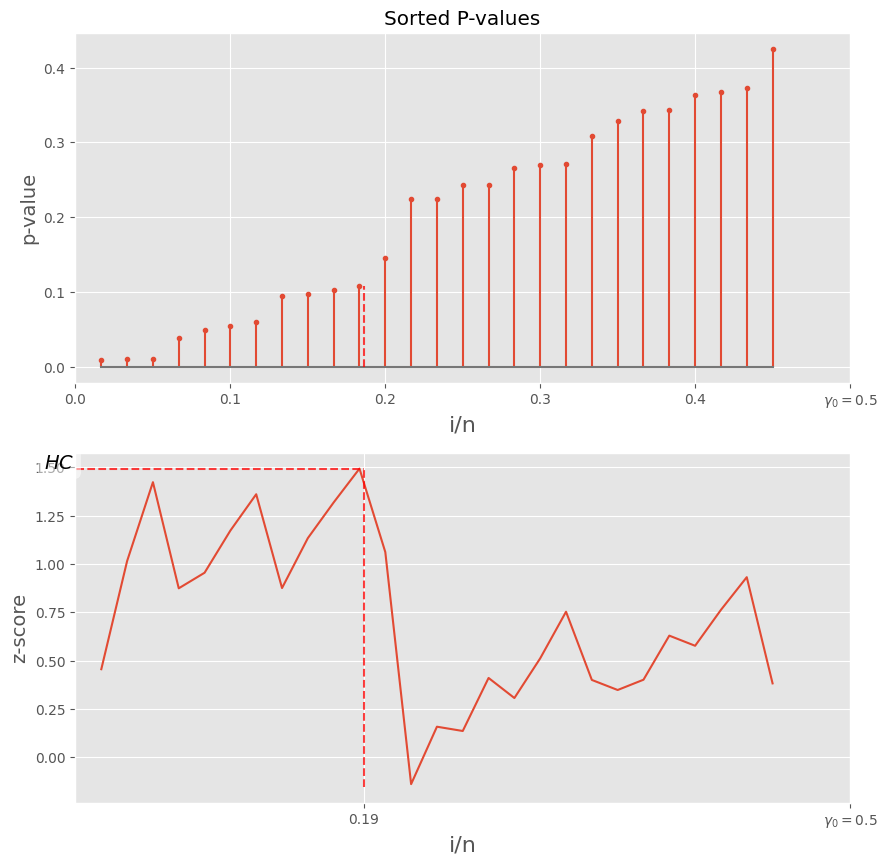

(1.4925783532718189, 0.1083)


/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_56688/1098204810.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_disp[~df_disp.pvalue.isna()].sort_values('pvalue')[df_disp['mask']]


,Unnamed: 0,sentence,response,pvalue,context,comment,mask,tag,len
55,55,\textcolor{blue}Stanislavski wrote :״Chekhov o...,4.771,0.0093,NaN,OK,True,<edit>,26
13,13,The intersection of his medical and...,3.685,0.0098,NaN,OK,True,no edits,28
28,28,The profound insights and nuanced characteriza...,3.920,0.0098,NaN,OK,True,no edits,28
56,56,\textcolor{blue}the characters often feel and ...,4.401,0.0385,NaN,OK,True,<edit>,14
45,45,"In summary, Anton Chekhov's major contribution...",3.444,0.0492,NaN,OK,True,no edits,30
8,8,"This event, coupled with the responsibility...",3.365,0.0544,NaN,OK,True,no edits,28
19,19,"\textcolor{blue}""The Steppe"" has been called a...",3.339,0.0600,NaN,OK,True,<edit>,39
32,32,He challenged traditional theatrical conventio...,3.462,0.0948,NaN,OK,True,no edits,24
18,18,"\textcolor{blue}In 1887, exhausted from overwo...",3.410,0.0975,NaN,OK,True,<edit>,32
11,11,Juggling medical studies with his literary...,3.797,0.1029,NaN,OK,True,no edits,19


In [3]:
file_name = "results/Anton Chekhov_edited_sentences.csv"

MIN_LEN = 10
df_doc1 = pd.read_csv(file_name)
df_doc1['len'] = df_doc1.sentence.apply(lambda x : len(x.split()))
df_doc1 = df_doc1[df_doc1.len > MIN_LEN]

df_disp = df_doc1
df_disp.loc[:, 'response'] = df_disp['response'].apply(lambda x : np.round(x,3))
df_disp.loc[:, 'pvalue'] = df_disp['pvalue'].apply(lambda x : np.round(x,4))
df_disp.loc[df_disp.tag == '<edit>', 'sentence'] = '\\textcolor{blue}' + df_disp.loc[df_disp.tag == '<edit>', 'sentence']

df_disp['sentence'] = df_disp['sentence'].apply(lambda x : " ".join(x.split()[:6]) + "...")


a = df_disp.filter(['sentence', 'response', 'pvalue'])
b = df_disp[df_disp['mask']].filter(['sentence', 'pvalue']).sort_values('pvalue')

from multitest import MultiTest
pvals = df_disp['pvalue']
mt = MultiTest(pvals[~np.isnan(pvals)], stbl=True)
mt.hc_dashboard(gamma=0.45)
print(mt.hc(gamma=0.45))

df_disp[~df_disp.pvalue.isna()].sort_values('pvalue')[df_disp['mask']]

In [38]:
print(df_disp.drop(['context', 'tag', 'mask', 'Unnamed: 0'], axis=1).to_latex())

\begin{tabular}{llrrlr}
\toprule
 & sentence & response & pvalue & comment & len \\
\midrule
2 & The Welsh Corgi, often simply referred... & 2.765000 & 0.210600 & OK & 29 \\
3 & Renowned for their distinctive appearance, characterized... & 2.864000 & 0.247400 & OK & 23 \\
4 & \textcolor{blue}Originally bred to herd cattle, sheep,... & 2.484000 & 0.597200 & OK & 21 \\
5 & This article delves into the fascinating... & 3.005000 & 0.444400 & OK & 16 \\
6 & From their origin as indispensable herding... & 3.682000 & 0.040000 & OK & 38 \\
7 & Moreover, we examine the different varieties... & 3.400000 & 0.058400 & OK & 22 \\
8 & Join us on this journey to... & 2.460000 & 0.289000 & OK & 31 \\
10 & The history of the Corgi breed... & 2.565000 & 0.540200 & OK & 24 \\
11 & \textcolor{blue}Corgi breeds are classified as Pembroke... & 2.327000 & 0.820700 & OK & 17 \\
12 & \textcolor{blue}The breeds are named for the... & 3.156000 & 0.161800 & OK & 18 \\
13 & Pembroke Welsh Corgi: The Pembroke Welsh

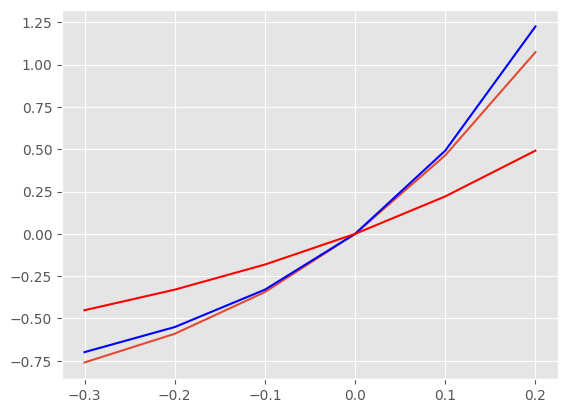

In [22]:
aa = np.arange(-.3,.3, 0.1)
m = 4
f = (1 + aa) ** m - 1
plt.plot(aa, f)
plt.plot(aa, np.exp(m*aa) - 1, color='blue')
plt.plot(aa, np.exp(m*aa/2) - 1, color='red')

In [215]:
print("General")
n_head = 9
n_tail = 3
df_sent = pd.concat([a.head(n_head), a.tail(n_tail)])
df_sent['sentence'] = df_sent['sentence'].apply(lambda x : " ".join(x.split()[:5]) + "...")
print(df_sent.to_latex(index=False))

General
\begin{tabular}{lrr}
\toprule
sentence & response & pvalue \\
\midrule
The Welsh Corgi, often simply... & 2.765000 & 0.212000 \\
Renowned for their distinctive appearance,... & 2.864000 & 0.242400 \\
\textcolor{blue}Originally bred to herd cattle,... & 2.484000 & 0.649000 \\
This article delves into the... & 3.005000 & 0.490400 \\
From their origin as indispensable... & 3.682000 & 0.041700 \\
Moreover, we examine the different... & 3.400000 & 0.116700 \\
Join us on this journey... & 2.460000 & 0.309300 \\
The history of the Corgi... & 2.565000 & 0.539500 \\
\textcolor{blue}Corgi breeds are classified as... & 2.266000 & 0.818700 \\
Overall, Welsh Corgis have become... & 2.456000 & 0.459400 \\
\textcolor{blue}They have surpassed their humble... & 3.906000 & 0.105700 \\
Their unique combination of historical... & 3.284000 & 0.077900 \\
\bottomrule
\end{tabular}



In [220]:
print("HCT")
n_head = 9
n_tail = 7
df_HCT = pd.concat([b.head(n_head), b.tail(n_tail)])
print(df_HCT.to_latex(index=False))

HCT
\begin{tabular}{lr}
\toprule
sentence & pvalue \\
\midrule
Despite their herding heritage gradually diminishing,... & 0.011300 \\
Corgi-themed fundraisers and charity events have... & 0.021100 \\
Legend has it that the fairies... & 0.034600 \\
\textcolor{blue}It is believed that the Cardigan... & 0.040000 \\
From their origin as indispensable herding... & 0.041700 \\
Cardigan Corgis were also adept herding... & 0.043500 \\
Their unique combination of historical significance,... & 0.077900 \\
\textcolor{blue}They have appeared in several animated... & 0.082000 \\
\textcolor{blue}They have surpassed their humble origins... & 0.105700 \\
They excelled at driving cattle and... & 0.177000 \\
Today, Welsh Corgis, especially the Pembroke,... & 0.185100 \\
Mascots and Symbols: In some regions,... & 0.188300 \\
Here are some ways in which... & 0.194200 \\
\textcolor{blue}The breeds are named for the... & 0.206500 \\
\textcolor{blue}A Welsh Corgi appeared with Queen... & 0.211400 \\
The Wels

In [228]:
14 + 81

95

General
\begin{tabular}{lrrl}
\toprule
sentence & response & pvalue & tag \\
\midrule
The Welsh Corgi, often simply... & 2.764900 & 0.212000 & not edit \\
Renowned for their distinctive appearance,... & 2.864000 & 0.242400 & not edit \\
Originally bred to herd cattle,... & 2.484400 & 0.649000 & <edit> \\
This article delves into the... & 3.004800 & 0.490400 & not edit \\
From their origin as indispensable... & 3.682400 & 0.041700 & not edit \\
Moreover, we examine the different... & 3.399900 & 0.116700 & not edit \\
Join us on this journey... & 2.459500 & 0.309300 & not edit \\
The history of the Corgi... & 2.564700 & 0.539500 & not edit \\
Corgi breeds are classified as... & 2.265500 & 0.818700 & <edit> \\
Corgi-themed fundraisers and charity events... & 3.635700 & 0.021100 & not edit \\
Overall, Welsh Corgis have become... & 2.456000 & 0.459400 & not edit \\
They have surpassed their humble... & 3.906100 & 0.105700 & <edit> \\
Their unique combination of historical... & 3.284100 & 0.

In [117]:
print(b.to_latex())

\begin{tabular}{llrr}
\toprule
 & sentence & response & pvalue \\
\midrule
0 & July 18 2023. & 4.780900 & NaN \\
1 & Welsh Corgi.

Introduction.
 & 4.839000 & NaN \\
2 & The Welsh Corgi, often simply referred to as Corgi, is a charming and beloved breed of herding dog with roots deeply entwined in the landscapes and folklore of Wales.
 & 2.764900 & 0.212000 \\
3 & Renowned for their distinctive appearance, characterized by their short legs and elongated bodies, Welsh Corgis have captured the hearts of dog enthusiasts worldwide.
 & 2.864000 & 0.242400 \\
4 & Originally bred to herd cattle, sheep, and horses, Corgis are celebrated for their intelligence, agility, unwavering loyalty, and eagerness to please. & 2.484400 & 0.649000 \\
5 & This article delves into the fascinating history, characteristics, and unique attributes of the Welsh Corgi breed.
 & 3.004800 & 0.490400 \\
6 & From their origin as indispensable herding aides in the verdant fields of Wales to their prominence as cherishe

In [107]:
a['response'] = a['response'].round(2)
a['pvalue'] = a['pvalue'].round(4)
print(a.head(6).to_latex(decimal=4))

TypeError: replace() argument 2 must be str, not int

0.030153015301530153

## Embedding

In [ ]:
api_key_path = '/Users/kipnisal/SybarIP/GPT4patents/api_key.txt'

api_key = open(api_key_path, 'r').read()

def openai_embedding(text, api_key=api_key):
    endpoint = 'https://api.openai.com/v1/embeddings'

    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {api_key}',
    }
    data = {
        "model": "text-embedding-ada-002",
        "input": text,
    }
    
    response = requests.post(endpoint, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        result = response.json()
    
        reply = result['data']
        if reply:
            list_vec = reply[0]['embedding']
            return np.array(list_vec)
        else:
            print("No reply from OpenAI.")
            return None
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

In [181]:
import glob
import requests
import json
articles_fns = glob.glob("/Users/kipnisal/Downloads/articles/*.txt")

embeddings = {}
texts = {}
labels = {}
for fn in articles_fns:
    # embed every article:
    with open(fn) as f:
        text = f.read()
    emb = openai_embedding(text)
    if emb is not None and len(emb) > 100:
        embeddings[fn] = emb
        texts[fn] = text
        labels[fn] = 1 if 'with_edits' in fn else 0
    else:
        print(f"Could not embed {fn}")

Error 400: {
  "error": {
    "message": "This model's maximum context length is 8192 tokens, however you requested 16692 tokens (16692 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.",
    "type": "invalid_request_error",
    "param": null,
    "code": null
  }
}

Could not embed /Users/kipnisal/Downloads/articles/article_1_without_edits.txt
Error 400: {
  "error": {
    "message": "This model's maximum context length is 8192 tokens, however you requested 19551 tokens (19551 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.",
    "type": "invalid_request_error",
    "param": null,
    "code": null
  }
}

Could not embed /Users/kipnisal/Downloads/articles/article_1_with_edits.txt


In [183]:
# use MLP to classify the articles based on their embeddings
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

X = np.vstack(list(embeddings.values()))
y = np.array(list(labels.values()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
clf.fit(X_train, y_train)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.00      0.00      0.00         2

    accuracy                           0.17         6
   macro avg       0.17      0.12      0.14         6
weighted avg       0.22      0.17      0.19         6



In [216]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(list(texts.values()), list(labels.values()), test_size=0.25, random_state=42)

# Create a pipeline with CountVectorizer, TfidfTransformer, and SVM
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='rbf'))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.4
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



/Users/kipnisal/Dropbox/Research/AuthorshipAI/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kipnisal/Dropbox/Research/AuthorshipAI/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kipnisal/Dropbox/Research/AuthorshipAI/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [191]:
y_pred_train = pipeline.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))

Accuracy: 0.5384615384615384


In [220]:
xx = np.array(pipeline['vect'].transform(X_train).sum(axis=1)).T[0].T
y_train = np.array(y_train)
xx[y_train == 1].mean(), xx[y_train == 0].mean()

(4117.142857142857, 3571.8333333333335)

False

In [214]:
y_train == 1

False